# Image Preperation

To prepare our dataset for use we will need to do some cleaning and normalizing of the pictures. 
First, we will use the bounding box information we gathered earlier so that our photos will only
have dogs in them. Then we will resize the images so that they are uniform in addition to 
normalizing the colors. 

After we have created our high quality dog images we will do some image augmentation to help 
under represented breeds (n < 200) and breed categories (wild dogs and Foundation Stock Service).
We will do this using 


In [53]:
#Import Dependencies
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET
import shutil

# Keras and TensorFlow imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

# KerasTuner imports
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch


In [54]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('resources/csv/dog_annotations_with_groups.csv')
df.head()

,filename,breed_name,folder,xmin,ymin,xmax,ymax,pose,truncated,difficult,group_x,group_y,group
0,n02085620_10074.jpg,chihuahua,n02085620-Chihuahua,25,10,276,498,Unspecified,0,0,Toy,Toy,Toy
1,n02085620_10131.jpg,chihuahua,n02085620-Chihuahua,49,9,393,493,Unspecified,0,0,Toy,Toy,Toy
2,n02085620_10621.jpg,chihuahua,n02085620-Chihuahua,142,43,335,250,Unspecified,0,0,Toy,Toy,Toy
3,n02085620_1073.jpg,chihuahua,n02085620-Chihuahua,0,27,312,498,Unspecified,0,0,Toy,Toy,Toy
4,n02085620_10976.jpg,chihuahua,n02085620-Chihuahua,90,104,242,452,Unspecified,0,0,Toy,Toy,Toy


In [55]:
# Expand crop box function with padding
def expand_bbox(xmin, ymin, xmax, ymax, img_width, img_height, padding=0.1):
    """Expand the bounding box by 10% padding and ensure it stays within the image bounds."""
    x_pad = int((xmax - xmin) * padding)
    y_pad = int((ymax - ymin) * padding)
    
    # Ensure the crop box stays within image bounds
    xmin = max(0, xmin - x_pad)
    ymin = max(0, ymin - y_pad)
    xmax = min(img_width, xmax + x_pad)
    ymax = min(img_height, ymax + y_pad)
    
    return xmin, ymin, xmax, ymax

# Main cropping loop
error_log = []
cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'
image_folder = 'resources/stanford-dogs-dataset/images'
breed_issues = {}

for _, row in df.iterrows():
    breed_name = row["breed_name"]
    folder_name = row["folder"].strip()  # Strip newlines & spaces
    filename = row["filename"].strip()  # Ensure filename is not empty

    # Check if filename is empty or incorrect
    if not filename or filename == "%s.jpg":
        error_log.append(f"Invalid filename for {breed_name} in {folder_name}")
        continue  # Skip this entry

    img_path = os.path.join(image_folder, folder_name, filename)

    if not os.path.exists(img_path):
        error_log.append(img_path)
        continue  # Skip missing images

    try:
        # Open image and get its size
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Update the bounding box with padding
        xmin, ymin, xmax, ymax = expand_bbox(row["xmin"], row["ymin"], row["xmax"], row["ymax"], img_width, img_height)

        # Crop the image based on the updated bounding box
        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        # Ensure breed folder exists for cropped images
        breed_cropped_path = os.path.join(cropped_folder, breed_name)
        os.makedirs(breed_cropped_path, exist_ok=True)

        # Save cropped image
        save_path = os.path.join(breed_cropped_path, filename)
        cropped_img.save(save_path)

    except Exception as e:
        error_log.append(f"{img_path} - {e}")

# Save error log
with open("missing_images_log.txt", "w") as f:
    for entry in error_log:
        f.write(f"{entry}\n")

print(f"✅ Cropping complete! {len(error_log)} issues logged.")


✅ Cropping complete! 1 issues logged.


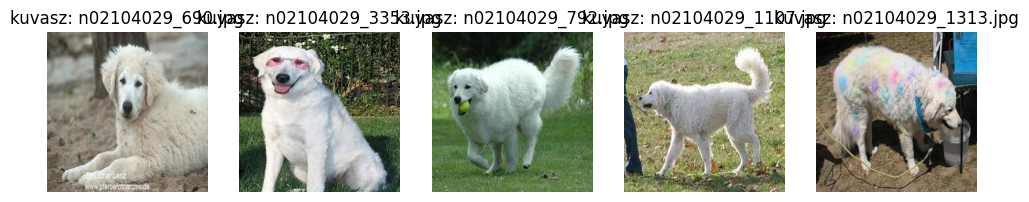

In [56]:
# Function to display a few cropped images
def check_cropped_images(cropped_folder, num_images=5, img_size=(256, 256)):
    """Randomly selects and displays cropped images."""
    breed_folders = os.listdir(cropped_folder)
    
    if not breed_folders:
        print("🚨 No breed folders found! Check your cropping process.")
        return

    breed_folder = random.choice(breed_folders)  # Pick a random breed
    breed_folder_path = os.path.join(cropped_folder, breed_folder)
    image_files = os.listdir(breed_folder_path)

    if not image_files:
        print(f"🚨 No images found in {breed_folder}! Check cropping.")
        return

    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(breed_folder_path, image_file)
        img = Image.open(img_path)
        img = img.resize(img_size)  # Resize for display consistency

        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.title(f"{breed_folder}: {image_file}")

    plt.show()

# Call function to visualize images
check_cropped_images(cropped_folder)


In [57]:
expected_breeds = set(df["breed_name"].unique())
actual_breeds = set(os.listdir(cropped_folder))

# Check which breeds are missing from the folders
missing_folders = expected_breeds - actual_breeds
extra_folders = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_folders)
print("📌 Extra breed folders that don't match dataset:", extra_folders)

📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()


In [58]:
total_imgs = 0
for breed in os.listdir(cropped_folder):
    breed_path = os.path.join(cropped_folder, breed)
    num_images = len(os.listdir(breed_path))
    total_imgs += num_images

print(f"There are {total_imgs} cropped images")
print(f"There are {len(df['breed_name']) - total_imgs} missing images.")


There are 20579 cropped images
There are 1547 missing images.


Updated Preprocessing with pre-trained models

In [59]:
# Set variables
IMG_SIZE = (256, 256)  # Image size
INPUT_SHAPE = (256, 256, 3)  # Image dimensions (RGB)
NUM_CLASSES = 120  # Number of dog breeds in your dataset
BATCH_SIZE = 32  # Number of images the model sees before backpropagating 

def resize_with_padding(image, target_size=IMG_SIZE):
    """Resize an image while keeping aspect ratio and adding padding."""
    image = np.array(image)  # Ensure it's a NumPy array
    
    # Convert image back to uint8 if it's in float32
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Normalize to [0, 255] and convert to uint8

    img = Image.fromarray(image)  # Convert to PIL Image
    img = ImageOps.fit(img, target_size, method=Image.Resampling.LANCZOS, centering=(0.5, 0.5)) 
    return np.array(img)  # Convert back to NumPy array





In [60]:
# Define ImageDataGenerator with the correct preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Now using ResNet's expected input format
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation split
)


In [61]:
# Function to get a random subset of images
def get_random_subset(image_folder, subset_size=6000):
    """Randomly select a subset of images for faster training/testing."""
    all_images = []
    for breed_folder in os.listdir(image_folder):
        breed_path = os.path.join(image_folder, breed_folder)
        if os.path.isdir(breed_path):
            all_images.extend([
                os.path.join(breed_path, img) for img in os.listdir(breed_path)
                if img.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    
    # Shuffle and select a random subset
    random.shuffle(all_images)
    subset_images = all_images[:subset_size]  # You can adjust subset_size as needed

    return subset_images

# Get random subset of images (30% of dataset)
random_subset = get_random_subset(cropped_folder, subset_size=6000)

# # Function to clear the temp_sample_folder
# def clear_temp_sample_folder(folder_path):
#     """Remove all files and subdirectories in the given folder."""
#     for breed_folder in os.listdir(folder_path):
#         breed_folder_path = os.path.join(folder_path, breed_folder)
#         if os.path.isdir(breed_folder_path):
#             shutil.rmtree(breed_folder_path)  # Delete breed folder and its contents

# # Clear temp_sample_folder before saving new images
# clear_temp_sample_folder(temp_sample_folder)

# Create a temporary directory for the sampled images
temp_sample_folder = 'resources/stanford-dogs-dataset/sample-cropped-images'
os.makedirs(temp_sample_folder, exist_ok=True)

# Copy the selected images to the temporary directory
for image_path in random_subset:
    breed_folder = image_path.split(os.sep)[-2]
    breed_folder_path = os.path.join(temp_sample_folder, breed_folder)
    os.makedirs(breed_folder_path, exist_ok=True)
    os.rename(image_path, os.path.join(breed_folder_path, os.path.basename(image_path)))

# Now, use the ImageDataGenerator with the sampled subset
train_generator = datagen.flow_from_directory(
    temp_sample_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    temp_sample_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4847 images belonging to 120 classes.
Found 1153 images belonging to 120 classes.


In [62]:
print(f"✅ Classes detected: {train_generator.class_indices}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")


✅ Classes detected: {'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired

In [63]:
# Get the list of breed names from your CSV file
expected_breeds = set(df["breed_name"].unique())

# Get the actual breed folders in your cropped folder
actual_breeds = set(os.listdir(cropped_folder))

# Check for missing and extra breeds
missing_breeds = expected_breeds - actual_breeds
extra_breeds = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_breeds)
print("📌 Extra breed folders that don't match dataset:", extra_breeds)

# Optionally, print the breeds that match
matching_breeds = expected_breeds & actual_breeds
print("📌 Matching breeds:", matching_breeds)


📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()
📌 Matching breeds: {'german_shepherd', 'cocker_spaniel', 'curly-coated_retriever', 'tibetan_terrier', 'bull_mastiff', 'lakeland_terrier', 'cairn', 'tibetan_mastiff', 'black-and-tan_coonhound', 'giant_schnauzer', 'airedale', 'appenzeller', 'yorkshire_terrier', 'entlebucher', 'english_setter', 'pug', 'malamute', 'komondor', 'shih-tzu', 'kelpie', 'borzoi', 'siberian_husky', 'saint_bernard', 'sealyham_terrier', 'papillon', 'italian_greyhound', 'afghan_hound', 'golden_retriever', 'rottweiler', 'toy_poodle', 'border_terrier', 'blenheim_spaniel', 'basset', 'pembroke', 'irish_wolfhound', 'maltese_dog', 'chow', 'miniature_schnauzer', 'doberman', 'weimaraner', 'norfolk_terrier', 'wire-haired_fox_terrier', 'miniature_poodle', 'affenpinscher', 'briard', 'basenji', 'cardigan', 'redbone', 'ibizan_hound', 'silky_terrier', 'bouvier_des_flandres', 'irish_setter', 'vizsla', 'english_springer',

In [64]:
# Check the class indices (label mappings) from the training generator
print("Class indices from the train generator:", train_generator.class_indices)

# Optionally, print the breed names and their corresponding labels
for breed, label in train_generator.class_indices.items():
    print(f"Breed: {breed} -> Label: {label}")


Class indices from the train generator: {'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 

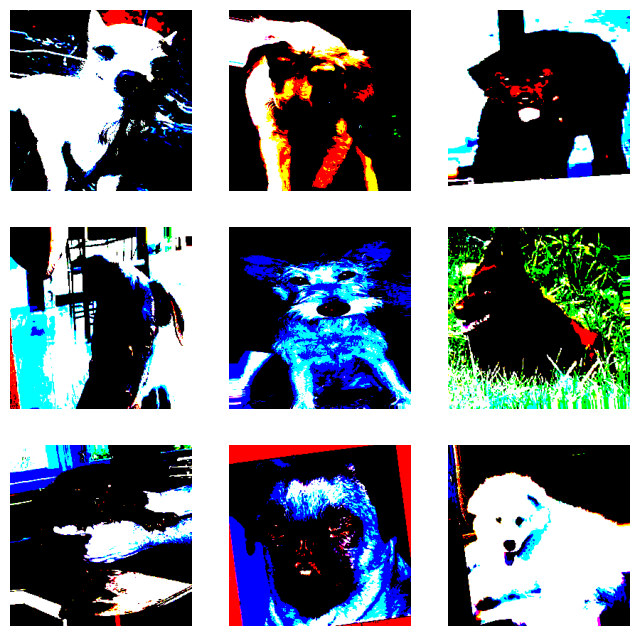

In [65]:
# Get a batch of augmented images from the train_generator
batch = next(val_generator)  # You can specify the generator name here

# Visualize 9 random images from the batch
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i])  # Images are in the first part of the batch
    ax.axis('off')
plt.show()


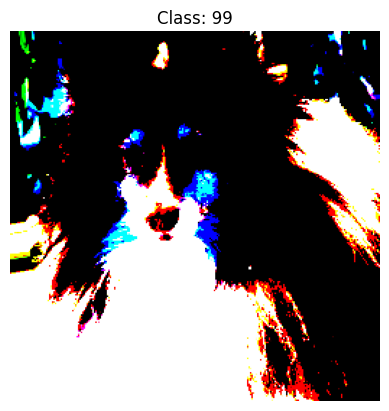

In [66]:
batch = next(train_generator)  # Get first batch
image, label = batch[0][0], batch[1][0]  # First image & label

plt.imshow((image + 1) / 2)  # Convert back to [0,1] range for viewing
plt.title(f"Class: {np.argmax(label)}")
plt.axis("off")
plt.show()


In [67]:
# Test if images are correctly preprocessed
batch_images, batch_labels = next(train_generator)
print(f"Image batch shape: {batch_images.shape}")  
print(f"Label batch shape: {batch_labels.shape}")  
print(f"Pixel range: min={batch_images.min()}, max={batch_images.max()}")  # Should be ~[-1, 1]

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 120)
Pixel range: min=-123.68000030517578, max=151.06100463867188


In [68]:
# Load ResNet50 pre-trained with ImageNet weights
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model
resnet_base_model.trainable = False

# Define the model
resnet_model = Sequential([
    resnet_base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Dropout for regularization (50% probability)
    Dense(1024, activation='relu'),  # Dense layer for learning
    Dropout(0.5),  # Another dropout layer for regularization
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Model summary to check architecture
resnet_model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │       123,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [69]:
# Early stopping callback (to stop training if no improvement)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint callback (to save the best model based on validation loss)
checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Fit the model with the training data and validation data
history = resnet_model.fit(
    train_generator,
    epochs=20,  # You can increase this if needed
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, checkpoint]  # Using early stopping and model checkpoint
)

c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0144 - loss: 5.4506
Epoch 1: val_loss improved from inf to 3.94984, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.0145 - loss: 5.4477 - val_accuracy: 0.2931 - val_loss: 3.9498
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0929 - loss: 4.1442
Epoch 2: val_loss improved from 3.94984 to 3.04373, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.0931 - loss: 4.1431 - val_accuracy: 0.4597 - val_loss: 3.0437
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2257 - loss: 3.3442
Epoch 3: val_loss improved from 3.04373 to 2.13602, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.2259 - loss: 3.3430 - val_accuracy: 0.5880 - val_loss: 2.1360
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3422 - loss: 2.6640
Epoch 4: val_loss improved from 2.13602 to 1.61228, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.3424 - loss: 2.6633 - val_accuracy: 0.6600 - val_loss: 1.6123
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4286 - loss: 2.1866 
Epoch 5: val_loss improved from 1.61228 to 1.33929, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 10743s 71s/step - accuracy: 0.4287 - loss: 2.1862 - val_accuracy: 0.6826 - val_loss: 1.3393
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5065 - loss: 1.8677 
Epoch 6: val_loss improved from 1.33929 to 1.14617, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 7202s 48s/step - accuracy: 0.5065 - loss: 1.8673 - val_accuracy: 0.7199 - val_loss: 1.1462
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.5326 - loss: 1.6865 
Epoch 7: val_loss improved from 1.14617 to 1.03476, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 3876s 26s/step - accuracy: 0.5327 - loss: 1.6862 - val_accuracy: 0.7476 - val_loss: 1.0348
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5871 - loss: 1.4628
Epoch 8: val_loss improved from 1.03476 to 0.97206, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.5871 - loss: 1.4628 - val_accuracy: 0.7476 - val_loss: 0.9721
Epoch 9/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6172 - loss: 1.3504
Epoch 9: val_loss improved from 0.97206 to 0.94969, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1438s 10s/step - accuracy: 0.6171 - loss: 1.3505 - val_accuracy: 0.7433 - val_loss: 0.9497
Epoch 10/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6239 - loss: 1.2845
Epoch 10: val_loss improved from 0.94969 to 0.90779, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.6240 - loss: 1.2843 - val_accuracy: 0.7485 - val_loss: 0.9078
Epoch 11/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6577 - loss: 1.1307
Epoch 11: val_loss improved from 0.90779 to 0.87004, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6576 - loss: 1.1309 - val_accuracy: 0.7615 - val_loss: 0.8700
Epoch 12/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6901 - loss: 1.0676
Epoch 12: val_loss improved from 0.87004 to 0.86224, saving model to best_resnet_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6900 - loss: 1.0678 - val_accuracy: 0.7580 - val_loss: 0.8622
Epoch 13/20
 53/152 ━━━━━━━━━━━━━━━━━━━━ 48:16 29s/step - accuracy: 0.6837 - loss: 1.0269

KeyboardInterrupt: 

In [70]:

# Check the history of validation accuracy
val_accuracy = history.history['val_accuracy']  # Get validation accuracy for each epoch

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(val_accuracy)  # Index of the best epoch

# Print out the best epoch and its validation accuracy
print(f"Best Epoch: {best_epoch + 1}, Validation Accuracy: {val_accuracy[best_epoch]}")





NameError: name 'history' is not defined

In [ ]:

# Save the model at the best epoch
mn_model.save('res_net_model.h5')  # Save model as .h5 file
print("First model saved as 'res_net_model.h5'")


First model saved as 'mobile_net_model.h5'


In [ ]:
# Find the best epoch based on validation loss (or accuracy)
best_epoch = np.argmin(history.history['val_loss'])  # Or 'val_accuracy' for accuracy-based stopping
print(f"Best Epoch: {best_epoch + 1}")
print(f"Validation Loss at Best Epoch: {history.history['val_loss'][best_epoch]}")
print(f"Validation Accuracy at Best Epoch: {history.history['val_accuracy'][best_epoch]}")